# To generate stellar parameters and abundances for whole Apogee DR14

### Please notice this notebook requires intensive computational resources to run for approx. few hours

### A pre-compiled Apogee DR14 stellar parameters and abundances with astroNN is avaliable in the git repository so you can use it directly, the order is exactly the same as Apogee DR14 allstar file

First we need to do continuum normalization on the whole Apogee DR14 combined spectra and save the file

In [ ]:
import numpy as np
import time
import h5py
from astropy.io import fits

from astroNN.apogee import allstar, visit_spectra
from astroNN.datasets import xmatch
from astroNN.gaia import mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error

target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask)

allstar_data = fits.getdata(allstar(dr=14))

start_time = time.time()

total_num = allstar_data['RA'].shape[0]
spec = np.zeros((total_num, 7514), dtype=np.float32)

for counter in range(0, total_num):
    if allstar_data['LOCATION_ID'][counter] == 1:
        continue
    ap_path = visit_spectra(dr=14, apogee=allstar_data['APOGEE_ID'][counter], 
                            location=allstar_data['LOCATION_ID'][counter], verbose=0)
    if ap_path is False:
        pass
    else:
        apstar_file = fits.open(ap_path)
        nvisits = apstar_file[0].header['NVISITS']
        # we only want combined spectra
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        
        if not np.all(_spec==0.):
            _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
            spec[counter] = _spec

    if counter % 100 == 0:
        print(f'Completed {counter} of {total_num}, {(time.time() - start_time):.{2}f}s elapsed')
        
# save a fits
hdu = fits.PrimaryHDU(spec)
hdu.writeto('contspec_dr14.fits')

Then we do inference on all combined spectra loaded from the compiled file and generate a catalog

In [ ]:
import numpy as np
import time
import h5py
from astropy.io import fits

from astroNN.apogee import allstar, visit_spectra
from astroNN.datasets import xmatch
from astroNN.gaia import mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error
from astroNN.models import load_folder

allstar_data = fits.getdata(allstar(dr=14))

net = load_folder("your_astroNN_model_here")

file = fits.open("contspec_dr14.fits")
allstar_file = fits.open(allstar(dr=14))
all_spec = file[0].data
        
pred, pred_error = net.test(all_spec)

# some spectra are all zeros, set prediction for those spectra to -9999.
pred[np.all(all_spec == 0., axis=1)] = -9999.
pred_error['total'][np.all(all_spec == 0., axis=1)] = -9999.

# save a fits
c1 = fits.Column(name='APOGEE_ID', array=allstar_data['APOGEE_ID'], format="18A")
c2 = fits.Column(name='LOCATION_ID', array=allstar_data['LOCATION_ID'], format="J")
c3 = fits.Column(name='RA', array=allstar_data['RA'], format='D')
c4 = fits.Column(name='DEC', array=allstar_data['DEC'], format='D')
c5 = fits.Column(name='astroNN', array=pred, format='22E')
c6 = fits.Column(name='astroNN_error', array=pred_error['total'], format='22E')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6])
t.writeto('astroNN_apogee_dr14_catalog.fits')

### Plot abundances across milkyway galaxy with Apogee BPG DIstance DR14

E:\sdss_mirror\dr14/apogee/vac/apogee-distances/apogee_distances-DR14.fits was found!
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!


(0, 16)

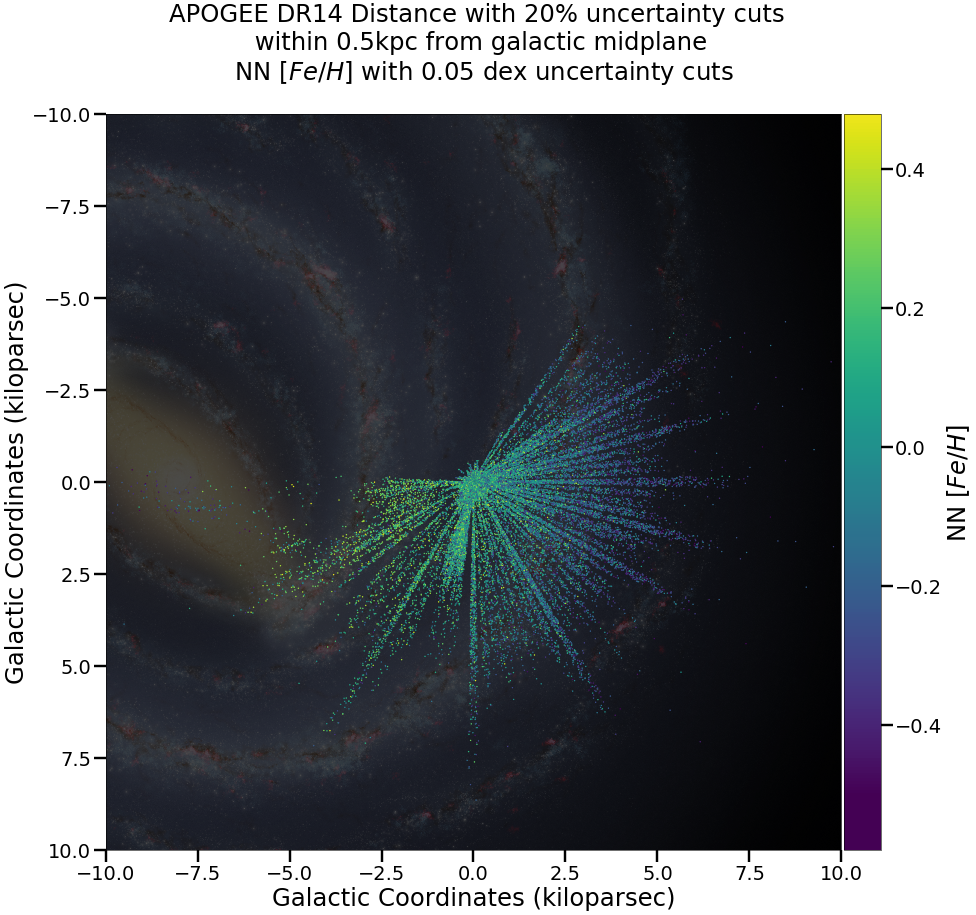

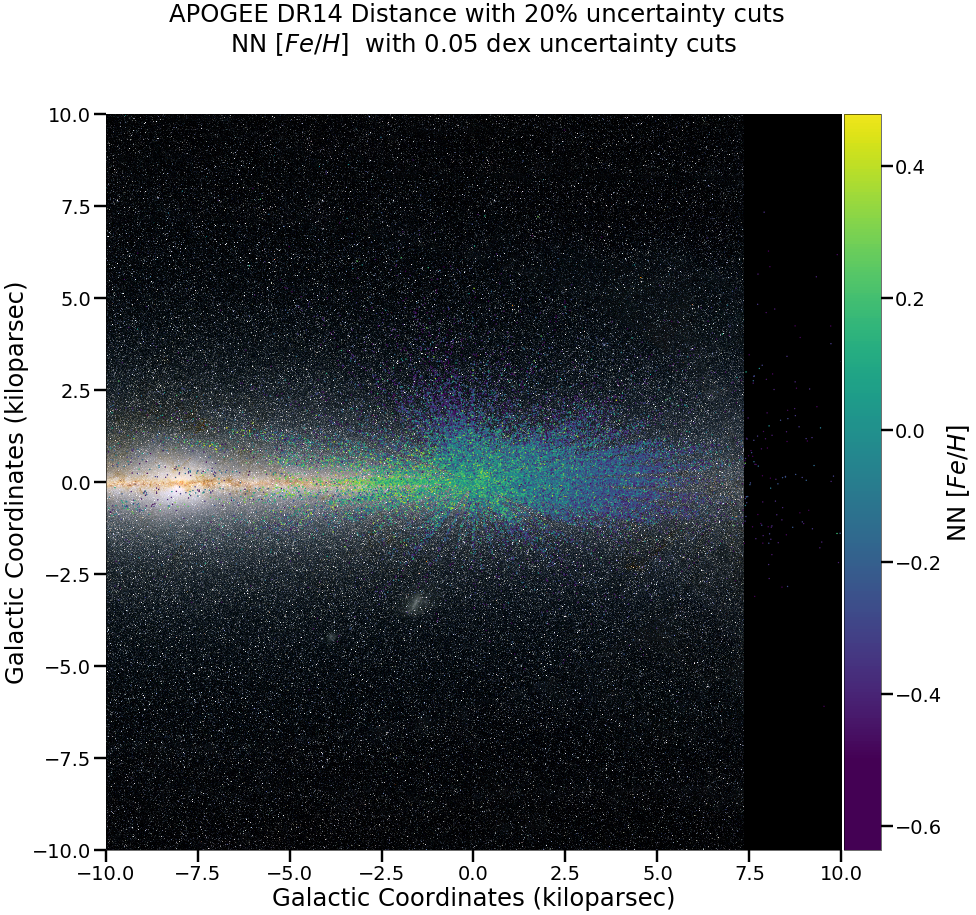

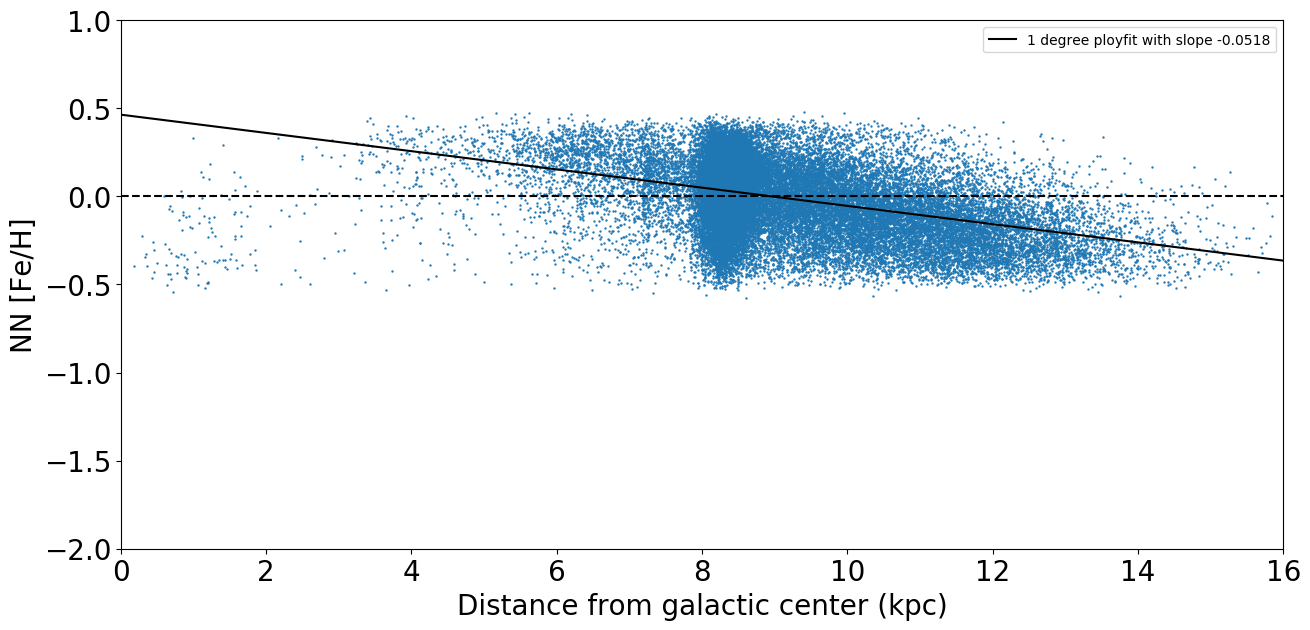

In [3]:
%matplotlib inline
from mw_plot import MWPlot
from astropy import units as  u
import astropy.coordinates as apycoords
from astropy.io import fits
import numpy as np
import pylab as plt
from astroNN.datasets import load_apogee_distances

# metric can be 'distance' for distance in parsec, 'absmag' for absolute magnitude and 'fakemag' for astroNN's fakemag scale
# cuts=True to cut out those unknown values (-9999.) and measurement error > 20%
RA, DEC, apogee_distance, apogee_distance_error = load_apogee_distances(dr=14, metric='distance', cuts=False)

f = fits.open("astroNN_apogee_dr14_catalog.fits")
FeH = f[1].data["astroNN"][:, 19]
FeH_uncertainty = f[1].data["astroNN_error"][:, 19]

ra = f[1].data["RA"] * u.deg
dec = f[1].data["DEC"]* u.deg
c = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx = [(apogee_distance_error / apogee_distance < 0.2) & (FeH != -9999.) & (FeH_uncertainty < 0.05) & 
            (np.abs(c.galactic.cartesian.z.value) < 500)]

c = c[good_idx]

# setup a MWPlot instance
plot_instance = MWPlot(radius=10 * u.kpc, unit=u.kpc, coord='galactic', annotation=False)

# so that the colorbar will has a better contract
plot_instance.clim = (-0.5, 0.5)
plot_instance.dpi=50

# alpha value for the milkyway image
plot_instance.imalpha = 0.3

# set up plot title
plot_instance.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n within 0.5kpc from galactic midplane \n NN $[Fe/H]$ with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                         [FeH[good_idx], 'NN $[Fe/H]$'])

plot_instance.tight_layout = False
# Save the figure
plot_instance.savefig(file='nn_feh_mw.png')
# =====================================================================================================
c2 = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx2 = [(apogee_distance_error / apogee_distance < 0.2) & (FeH != -9999.) & (FeH_uncertainty < 0.05)]
c2 = c2[good_idx2]

# setup a MWPlot instance
plot_instance2 = MWPlot(mode='edge-on', radius=10 * u.kpc, unit=u.kpc, coord='galactic')

# so that the colorbar will has a better contract
plot_instance2.clim = (-0.5, 0.5)
plot_instance2.dpi=50

# alpha value for the milkyway image
plot_instance2.imalpha = 1.0

# set up plot title
plot_instance2.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n NN $[Fe/H]$  with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance2.mw_scatter(-c2.galactic.cartesian.x, c2.galactic.cartesian.z,
                          [FeH[good_idx2], 'NN $[Fe/H]$'])

plot_instance2.tight_layout = False
# Save the figure
# plot_instance.savefig(file='gaia.png')
#==========================================================================================================
r = np.sqrt(c.galactocentric.cartesian.x.value**2 + c.galactocentric.cartesian.y.value**2 + 
                    c.galactocentric.cartesian.z.value**2) / 1000

z_fit = np.polyfit(r, FeH[good_idx], 1)

f = plt.figure(figsize=(15, 7), dpi=100)
plt.scatter(r, FeH[good_idx], s=0.5)
plt.plot(np.arange(0, 17), np.poly1d(z_fit)(np.arange(0, 17)), c='k', label=f'1 degree ployfit with slope {z_fit[0]:.{4}f}')
plt.axhline(0., c='k', ls='--')
plt.xlabel('Distance from galactic center (kpc)', fontsize=20)
plt.ylabel('NN [Fe/H]', fontsize=20)
plt.ylim(-2, 1)
plt.tick_params(labelsize=20)
plt.legend()
plt.xlim(0, 16)

E:\sdss_mirror\dr14/apogee/vac/apogee-distances/apogee_distances-DR14.fits was found!
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!


C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


(0, 16)

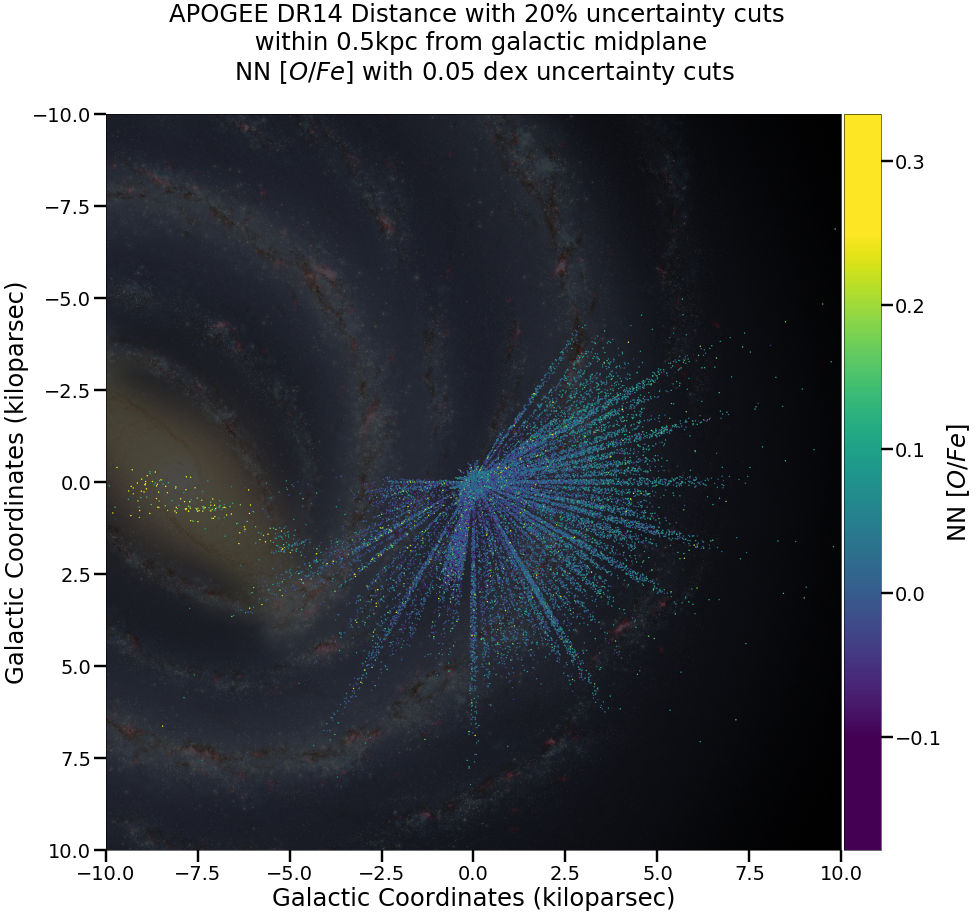

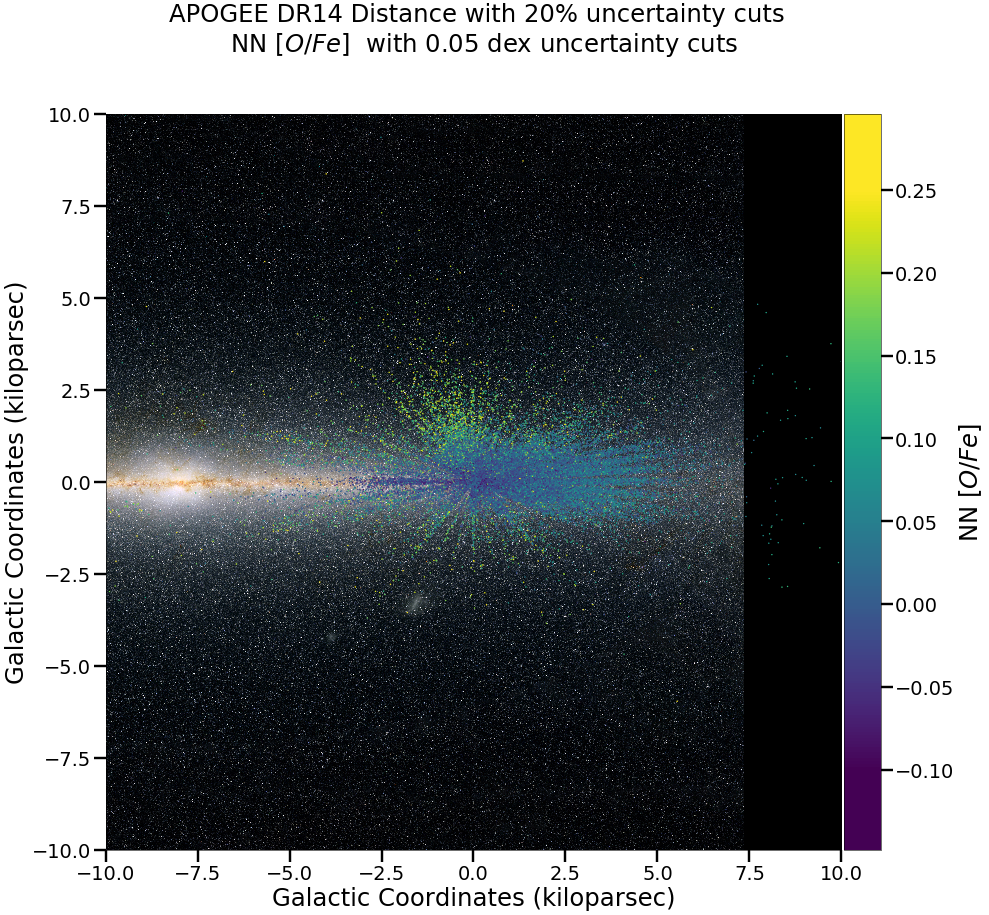

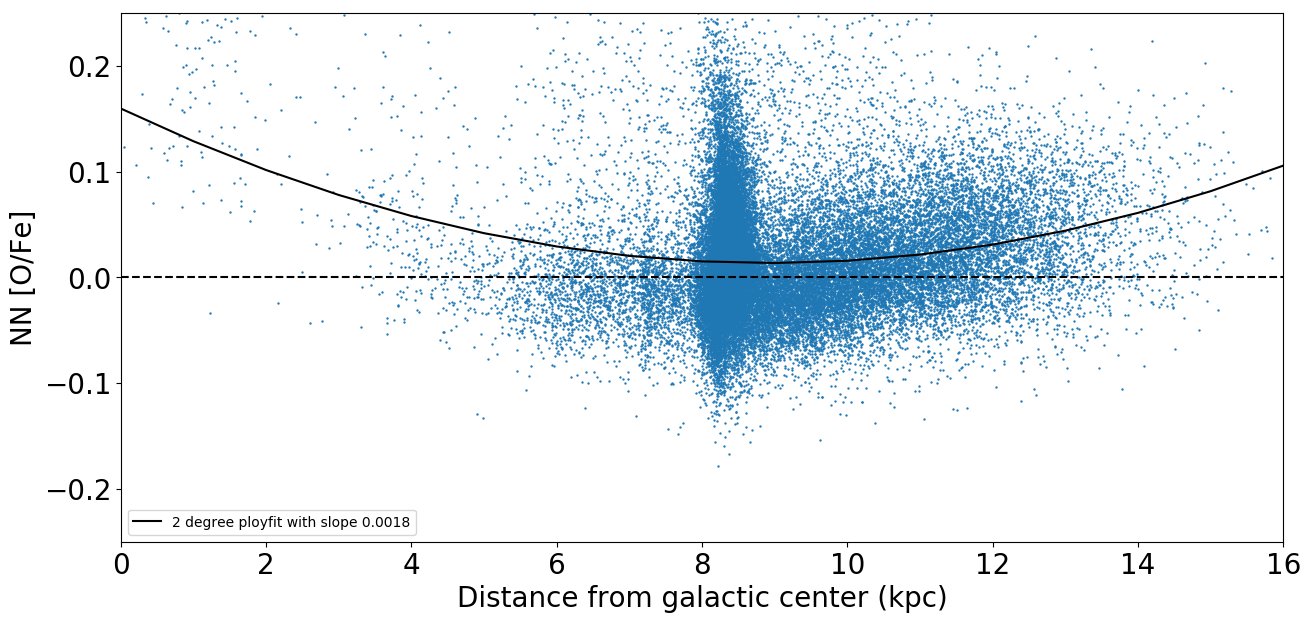

In [4]:
%matplotlib inline
from mw_plot import MWPlot
from astropy import units as  u
import astropy.coordinates as apycoords
from astropy.io import fits
import numpy as np
import pylab as plt
from astroNN.datasets import load_apogee_distances

# metric can be 'distance' for distance in parsec, 'absmag' for absolute magnitude and 'fakemag' for astroNN's fakemag scale
# cuts=True to cut out those unknown values (-9999.) and measurement error > 20%
RA, DEC, apogee_distance, apogee_distance_error = load_apogee_distances(dr=14, metric='distance', cuts=False)

f = fits.open("astroNN_apogee_dr14_catalog.fits")
OFe = f[1].data["astroNN"][:, 5] - f[1].data["astroNN"][:, 19]
OFe_uncertainty = np.sqrt(f[1].data["astroNN_error"][:, 5] **2 + f[1].data["astroNN_error"][:, 19] ** 2)

ra = f[1].data["RA"] * u.deg
dec = f[1].data["DEC"]* u.deg
c = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx = [(apogee_distance_error / apogee_distance < 0.2) & (OFe != -9999.) & (OFe_uncertainty < 0.071) & 
            (np.abs(c.galactic.cartesian.z.value) < 500)]

c = c[good_idx]

# setup a MWPlot instance
plot_instance = MWPlot(radius=10 * u.kpc, unit=u.kpc, coord='galactic', annotation=False)

# so that the colorbar will has a better contract
plot_instance.clim = (-0.1, 0.25)
plot_instance.dpi=50

# alpha value for the milkyway image
plot_instance.imalpha = 0.3

# set up plot title
plot_instance.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n within 0.5kpc from galactic midplane \n NN $[O/Fe]$ with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                         [OFe[good_idx], 'NN $[O/Fe]$'])

plot_instance.tight_layout = False
# Save the figure
plot_instance.savefig(file='nn_ofe_mw.png')
# =====================================================================================================
c2 = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx2 = [(apogee_distance_error / apogee_distance < 0.2) & (OFe != -9999.) & (OFe_uncertainty < 0.05) ]
c2 = c2[good_idx2]

# setup a MWPlot instance
plot_instance2 = MWPlot(mode='edge-on', radius=10 * u.kpc, unit=u.kpc, coord='galactic')

# so that the colorbar will has a better contract
plot_instance2.clim = (-0.1, 0.25)
plot_instance2.dpi=50

# alpha value for the milkyway image
plot_instance2.imalpha = 1.0

# set up plot title
plot_instance2.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n NN $[O/Fe]$  with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance2.mw_scatter(-c2.galactic.cartesian.x, c2.galactic.cartesian.z,
                          [OFe[good_idx2], 'NN $[O/Fe]$'])

plot_instance2.tight_layout = False
# Save the figure
# plot_instance.savefig(file='gaia.png')
#==========================================================================================================
r = np.sqrt(c.galactocentric.cartesian.x.value**2 + c.galactocentric.cartesian.y.value**2 + 
                    c.galactocentric.cartesian.z.value**2) / 1000

z_fit = np.polyfit(r, OFe[good_idx], 2)

f = plt.figure(figsize=(15, 7), dpi=100)
plt.scatter(r, OFe[good_idx], s=0.5)
plt.plot(np.arange(0, 17), np.poly1d(z_fit)(np.arange(0, 17)), c='k', label=f'2 degree ployfit with slope {z_fit[0]:.{4}f}')
plt.axhline(0., c='k', ls='--')
plt.xlabel('Distance from galactic center (kpc)', fontsize=20)
plt.ylabel('NN [O/Fe]', fontsize=20)
plt.ylim(-0.25, 0.25)
plt.tick_params(labelsize=20)
plt.legend()
plt.xlim(0, 16)

E:\sdss_mirror\dr14/apogee/vac/apogee-distances/apogee_distances-DR14.fits was found!
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!


C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


(0, 16)

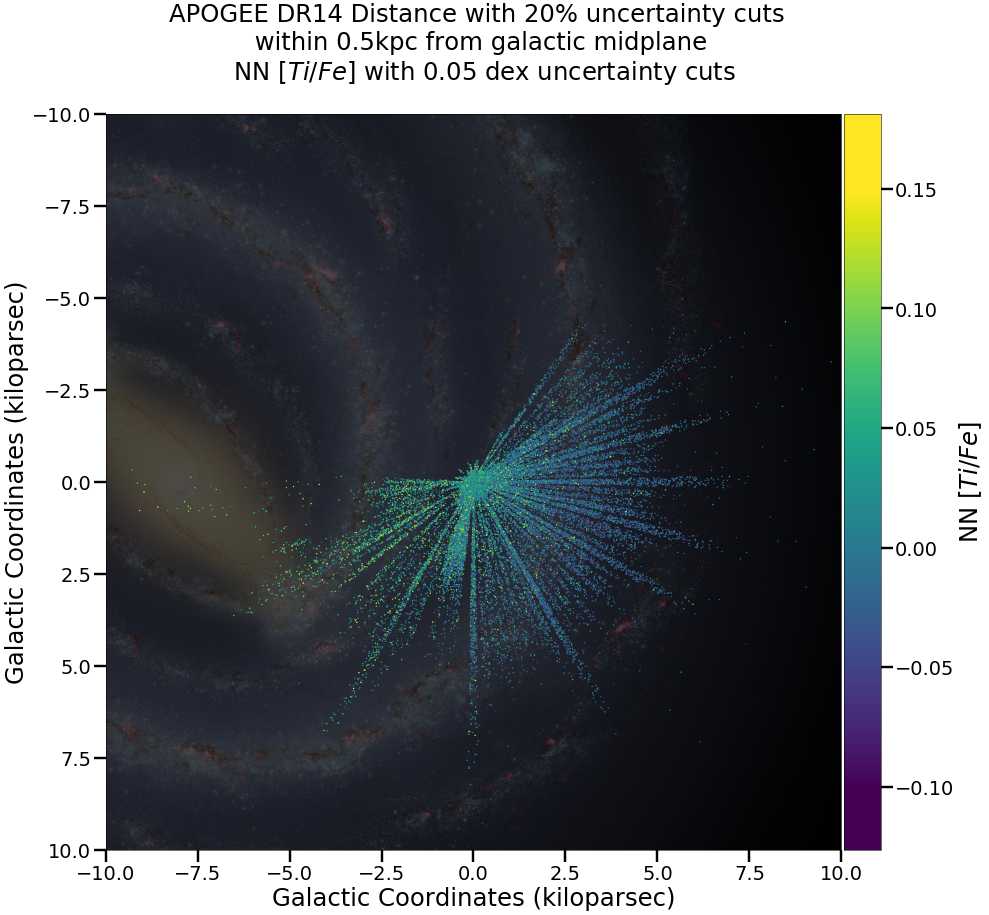

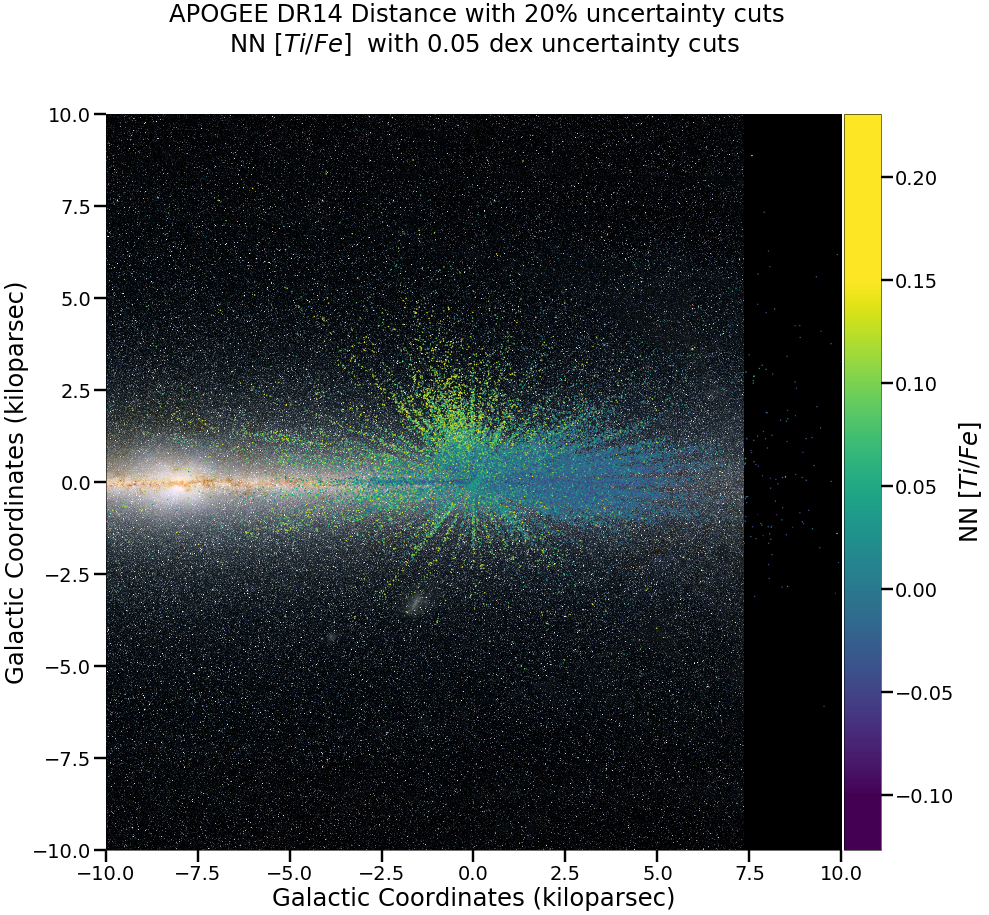

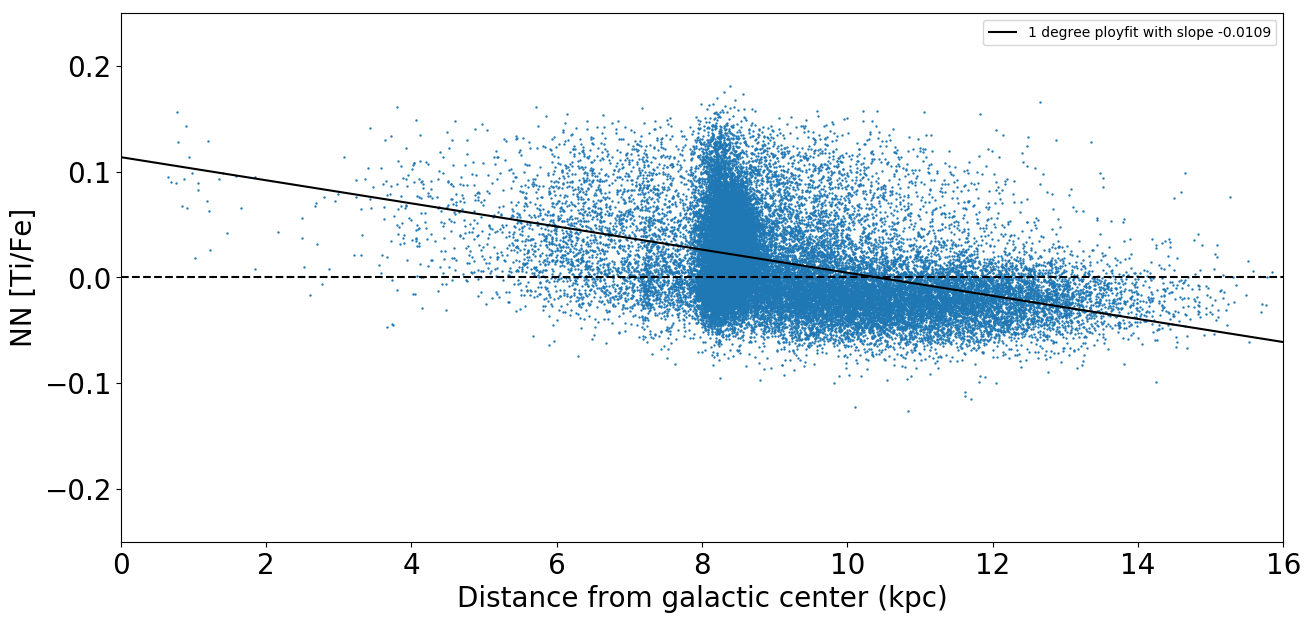

In [2]:
%matplotlib inline
from mw_plot import MWPlot
from astropy import units as  u
import astropy.coordinates as apycoords
from astropy.io import fits
import numpy as np
import pylab as plt
from astroNN.datasets import load_apogee_distances

# metric can be 'distance' for distance in parsec, 'absmag' for absolute magnitude and 'fakemag' for astroNN's fakemag scale
# cuts=True to cut out those unknown values (-9999.) and measurement error > 20%
RA, DEC, apogee_distance, apogee_distance_error = load_apogee_distances(dr=14, metric='distance', cuts=False)

f = fits.open("astroNN_apogee_dr14_catalog.fits")
TiFe = f[1].data["astroNN"][:, 14] - f[1].data["astroNN"][:, 19]
TiFe_uncertainty = np.sqrt(f[1].data["astroNN_error"][:, 14] **2 + f[1].data["astroNN_error"][:, 19] ** 2)

ra = f[1].data["RA"] * u.deg
dec = f[1].data["DEC"]* u.deg
c = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx = [(apogee_distance_error / apogee_distance < 0.2) & (TiFe != -9999.) & (TiFe_uncertainty < 0.071) & 
            (np.abs(c.galactic.cartesian.z.value) < 500)]

c = c[good_idx]

# setup a MWPlot instance
plot_instance = MWPlot(radius=10 * u.kpc, unit=u.kpc, coord='galactic', annotation=False)

# so that the colorbar will has a better contract
plot_instance.clim = (-0.1, 0.15)
plot_instance.dpi=50

# alpha value for the milkyway image
plot_instance.imalpha = 0.3

# set up plot title
plot_instance.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n within 0.5kpc from galactic midplane \n NN $[Ti/Fe]$ with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_scatter(-c.galactic.cartesian.x, c.galactic.cartesian.y,
                         [TiFe[good_idx], 'NN $[Ti/Fe]$'])

plot_instance.tight_layout = False
# Save the figure
plot_instance.savefig(file='nn_tife_mw.png')
# =====================================================================================================
c2 = apycoords.SkyCoord(ra=ra, dec=dec, distance=apogee_distance * u.parsec, frame='icrs')

good_idx2 = [(apogee_distance_error / apogee_distance < 0.2) & (TiFe != -9999.) & (TiFe_uncertainty < 0.071) ]
c2 = c2[good_idx2]

# setup a MWPlot instance
plot_instance2 = MWPlot(mode='edge-on', radius=10 * u.kpc, unit=u.kpc, coord='galactic')

# so that the colorbar will has a better contract
plot_instance2.clim = (-0.1, 0.15)
plot_instance2.dpi=50

# alpha value for the milkyway image
plot_instance2.imalpha = 1.0

# set up plot title
plot_instance2.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n NN $[Ti/Fe]$  with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance2.mw_scatter(-c2.galactic.cartesian.x, c2.galactic.cartesian.z,
                          [TiFe[good_idx2], 'NN $[Ti/Fe]$'])

plot_instance2.tight_layout = False
# Save the figure
# plot_instance.savefig(file='gaia.png')
#==========================================================================================================
r = np.sqrt(c.galactocentric.cartesian.x.value**2 + c.galactocentric.cartesian.y.value**2 + 
                    c.galactocentric.cartesian.z.value**2) / 1000

z_fit = np.polyfit(r, TiFe[good_idx], 1)

f = plt.figure(figsize=(15, 7), dpi=100)
plt.scatter(r, TiFe[good_idx], s=0.5)
plt.plot(np.arange(0, 17), np.poly1d(z_fit)(np.arange(0, 17)), c='k', label=f'1 degree ployfit with slope {z_fit[0]:.{4}f}')
plt.axhline(0., c='k', ls='--')
plt.xlabel('Distance from galactic center (kpc)', fontsize=20)
plt.ylabel('NN [Ti/Fe]', fontsize=20)
plt.ylim(-0.25, 0.25)
plt.tick_params(labelsize=20)
plt.legend()
plt.xlim(0, 16)